In [ ]:
import math
import os

import decoupler as dc
import matplotlib.pyplot as plt
import mofaflex as mf
import mudata as md
import scanpy as sc

import mina

In [2]:
os.getcwd()

'/home/klaus/mina_v0'

## Importing the data

Here we start by importing a single-cell dataset of heart failure

In [ ]:
file_names = ["/your/path/here/Chaffin2022_DCM.h5ad"]
batch_names = ["Chaffin"]
chaffin_dat = sc.read_h5ad(filename=file_names[0])  # we define the Anndata object that we are going to evaluate

Extracting meta data at the sample level is necessary to understand the samples used to build the multicellular map

In [ ]:
metadata = mina.up.pp.extract_metadata_from_obs(obs=chaffin_dat.obs, groupby="sample_id", sort=False)

Notes to dev: we need to be flexible in the manipulation of sample ids so as it doesn't crash whenever we don't have "sample_id"

## Pseudobulking - decoupleR

In [5]:
pdata = dc.pp.pseudobulk(chaffin_dat, sample_col="sample_id", groups_col="cell_type")

In [ ]:
# Manipulations on pdata - Needed?
pdata.obs = pdata.obs.set_index("sample_id", drop=False)
pdata.obs.index.name = None

## Separating pseudobulk into cell-types (views)

In [ ]:
anndata_dict = mina.up.pp.split_anndata_by_celltype(pdata=pdata, grouping="cell_type")

# Adding gene expression total counts - TODO add to upstream as a function

for _cell_type, adata in anndata_dict.items():
    # Sum across observations (rows) for each gene (column)
    if hasattr(adata.X, "toarray"):
        # Sparse matrix case
        total_counts = adata.X.sum(axis=0).A1  # returns 1D array
    else:
        total_counts = adata.X.sum(axis=0)  # numpy array

    # Add to .var
    adata.var["total_counts"] = total_counts

### Filtering - How many cells per pseudobulk (20 cells recommended)

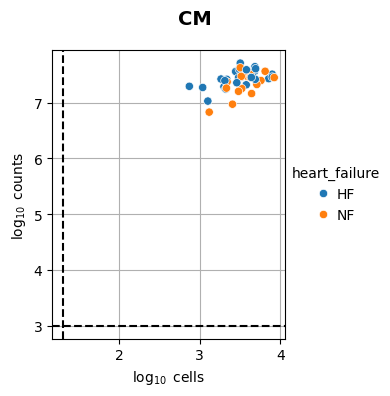

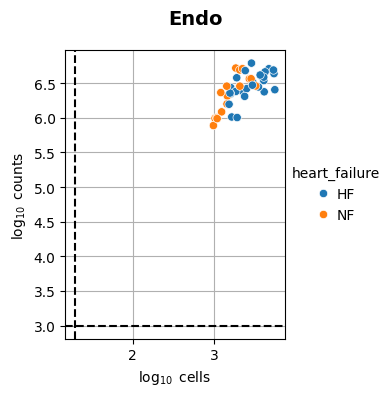

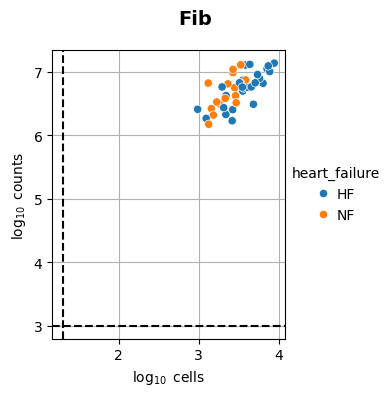

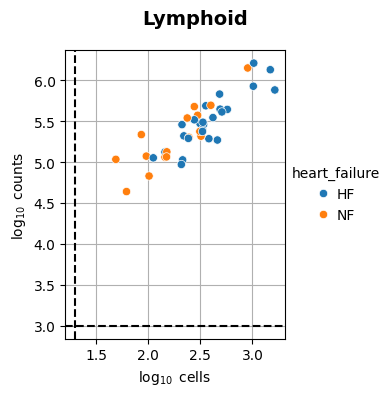

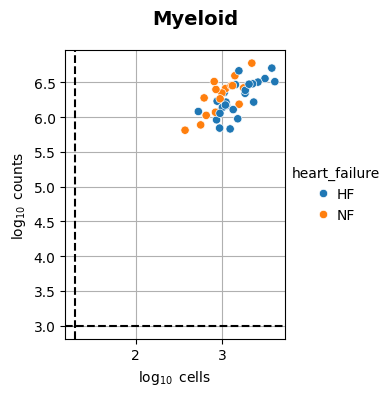

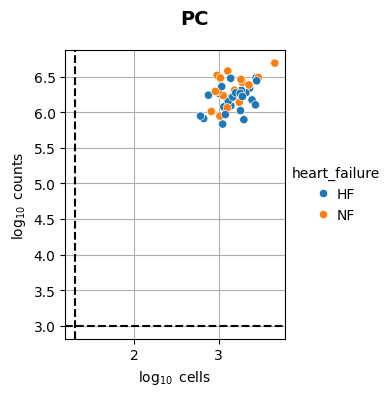

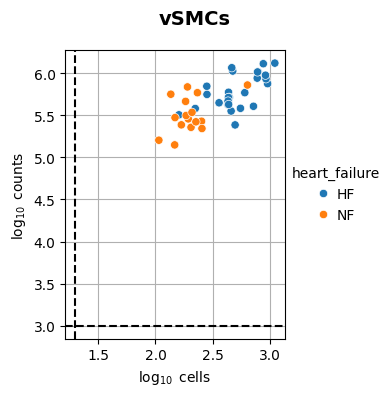

In [8]:
for x, y in anndata_dict.items():
    dc.pl.filter_samples(y, groupby=["heart_failure"], min_cells=20, min_counts=1000, figsize=(4, 4))

    plt.gcf().suptitle(f"{x}", fontsize=14, fontweight="bold")

    plt.show()

In [9]:
mina.up.filt.filter_anndata_by_ncells(anndata_dict, min_cells=20)

### Filtering views by number of patients

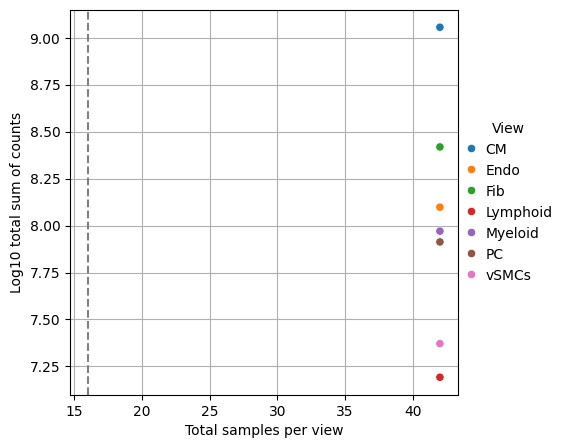

In [10]:
# From all the possible samples, let's ask for at least 40%
n_samples = len(metadata.index)
min_samples = math.trunc(n_samples * 0.4)
mina.pl.plot_view_samples(anndata_dict, min_samples=min_samples)
mina.up.filt.filter_views_by_samples(anndata_dict, min_rows=min_samples)

### Filtering by gene expression

First we visualize in how many samples the gene is expressed and the minimum number of counts

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


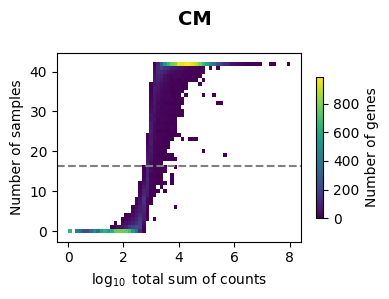

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


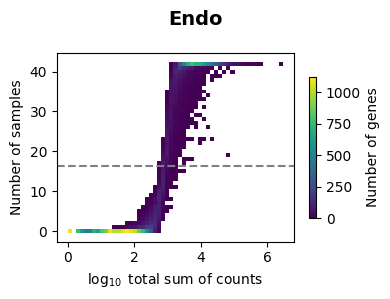

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


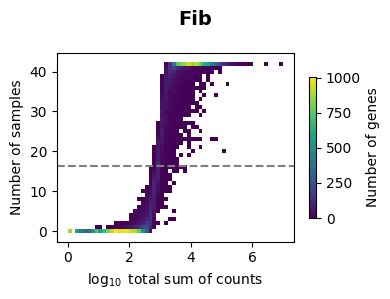

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


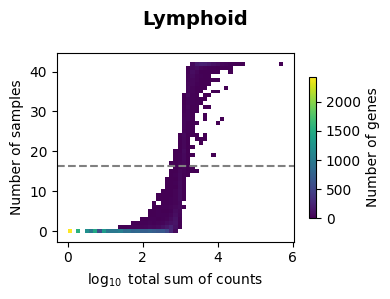

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


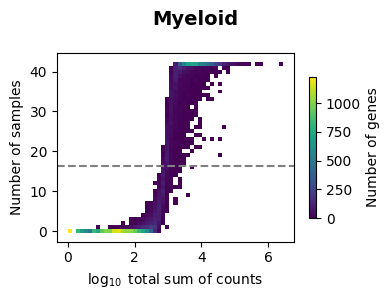

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


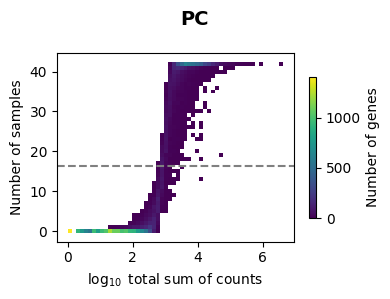

/home/klaus/miniforge3/envs/create_mina_test_v0/lib/python3.13/site-packages/decoupler/pl/_filter_by_expr.py:82: RuntimeWarning: divide by zero encountered in log10


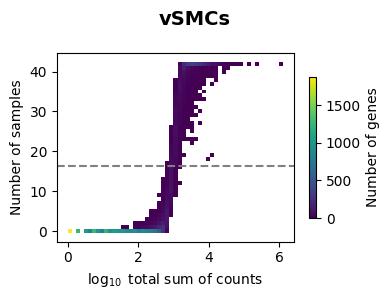

In [11]:
for x, y in anndata_dict.items():
    dc.pl.filter_by_expr(y, min_count=20, min_total_count=0, large_n=0, min_prop=0.4)

    plt.gcf().suptitle(f"{x}", fontsize=14, fontweight="bold")

    plt.show()

In [12]:
mina.up.filt.filter_genes_byexpr(anndata_dict, min_count=20, min_prop=0.4)

### Filtering views by total genes after that

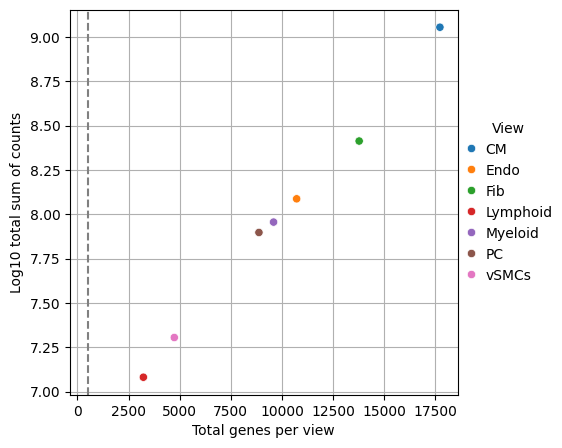

In [13]:
mina.pl.plot_view_genes(anndata_dict, min_genes=500, table=False)
mina.up.filt.filter_views_by_genes(anndata_dict, min_genes_per_view=500)

### Filtering samples within a view that have very limited gene coverage

{'CM': <Figure size 500x500 with 1 Axes>,
 'Endo': <Figure size 500x500 with 1 Axes>,
 'Fib': <Figure size 500x500 with 1 Axes>,
 'Lymphoid': <Figure size 500x500 with 1 Axes>,
 'Myeloid': <Figure size 500x500 with 1 Axes>,
 'PC': <Figure size 500x500 with 1 Axes>,
 'vSMCs': <Figure size 500x500 with 1 Axes>}

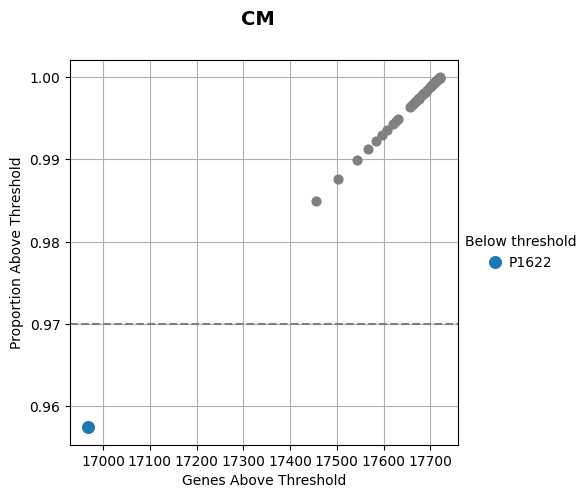

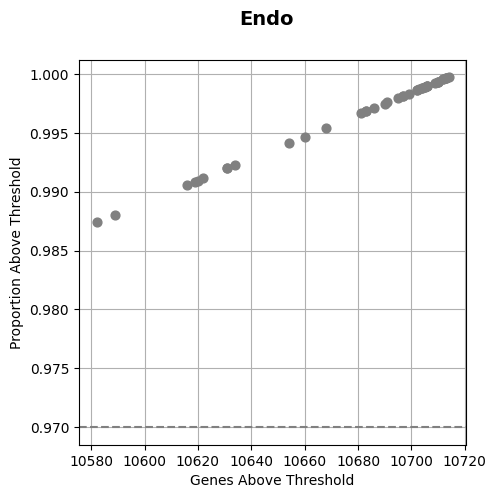

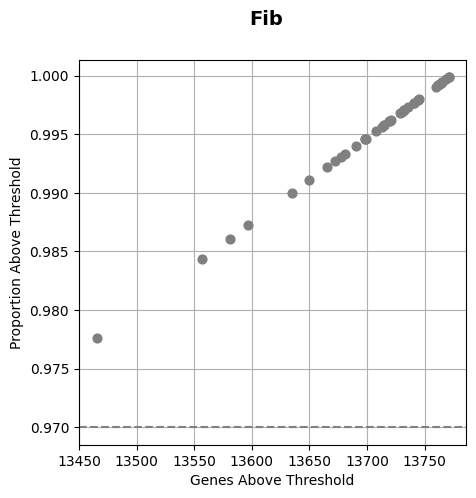

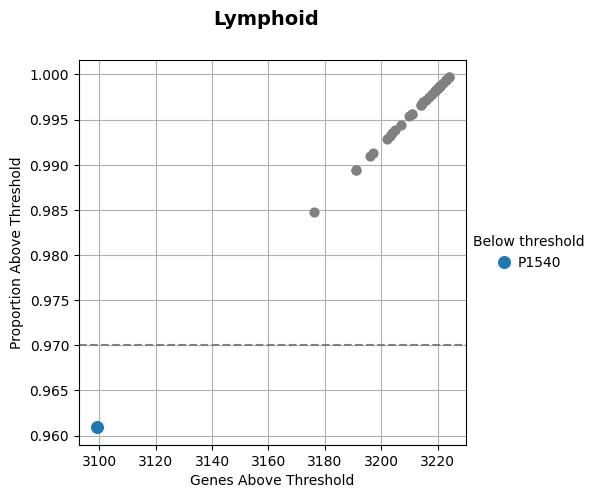

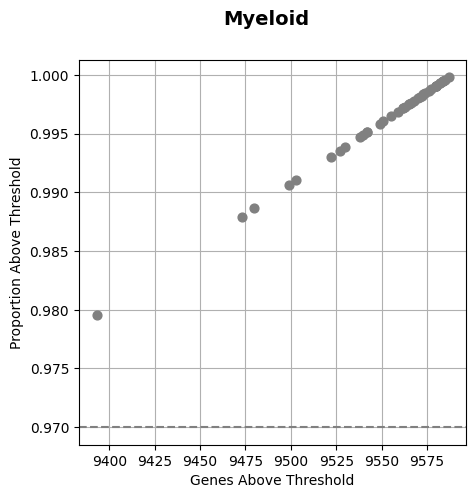

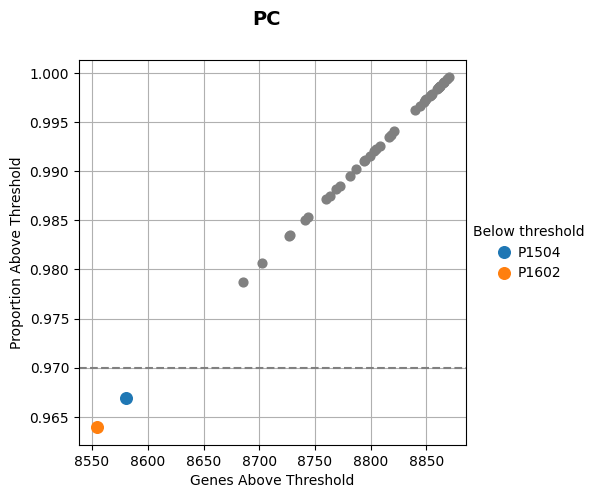

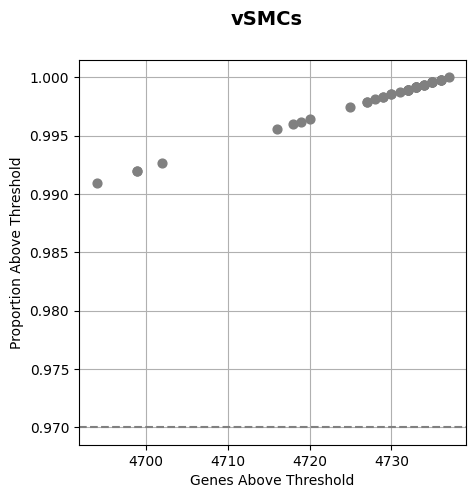

In [14]:
mina.pl.plot_sample_coverage(
    anndata_dict,
    threshold=0,  # or {'CM': 0, 'Endo': 0, ...}
    proportion=0.97,  # or {'CM': 0.95, 'Endo': 0.97, ...}
    return_fig=True,
)

In [15]:
mina.up.filt.filter_samples_by_coverage(anndata_dict, threshold=0, min_prop=0.97)

### Now we normalize data and select highly variable genes

In [16]:
mina.up.utils.save_raw_counts(anndata_dict, layer_name="raw_counts")
mina.up.pp.norm_log(anndata_dict, target_sum=1e6, exclude_highly_expressed=False, max_value=None, center=True)
mina.up.filt.filter_hvgs(anndata_dict)
# You can also filter by background genes if you have those
# up.filter_genes_by_celltype(anndata_dict, test_list)

Raw counts saved in the 'raw_counts' layer for each AnnData object.
Normalization, log-transformation, and scaling complete for all AnnData objects with target_sum = 1000000.0.


In [17]:
anndata_dict["CM"].var

,gene_ids,feature_types,genome,total_counts,mean,std
ADGRV1,ENSG00000164199,Gene Expression,GRCh38-2020-A_premrna,5026.0,1.663448,0.287600
AC020900.1,ENSG00000249180,Gene Expression,GRCh38-2020-A_premrna,2230.0,1.030370,0.403710
CHFR,ENSG00000072609,Gene Expression,GRCh38-2020-A_premrna,57547.0,3.939128,0.138487
LRAT,ENSG00000121207,Gene Expression,GRCh38-2020-A_premrna,1390.0,0.790875,0.254297
SERBP1,ENSG00000142864,Gene Expression,GRCh38-2020-A_premrna,42940.0,3.659914,0.135130
...,...,...,...,...,...,...
KBTBD6,ENSG00000165572,Gene Expression,GRCh38-2020-A_premrna,4357.0,1.524157,0.307741
OTOGL,ENSG00000165899,Gene Expression,GRCh38-2020-A_premrna,6926.0,1.817407,0.638375
PLXNB1,ENSG00000164050,Gene Expression,GRCh38-2020-A_premrna,11348.0,2.394258,0.237758
ARID1A,ENSG00000117713,Gene Expression,GRCh38-2020-A_premrna,128865.0,4.737523,0.163453


Note to devs: We are using a very shallow way of filtering highly variable genes (seurat version in scanpy). We should let the user use which ever hvg function they want from scanpy

## Modeling

In [ ]:
# Run this to avoid doing all the modeling if you crash
mina.up.utils.append_view_to_var(anndata_dict)
modelSOFA = mf.MOFAFLEX.load("." + "/data/Chaffin2022_SOFA" + ".h5mu")
modelMOFA = mf.MOFAFLEX.load("." + "/data/Chaffin2022_MOFA" + ".h5mu")

2025-10-20 15:59:01 | [WARNING] The stored model was created with a different version of MOFA-FLEX. Some features may not work.
2025-10-20 15:59:01 | [WARNING] The stored model was created with a different version of MOFA-FLEX. Some features may not work.


Note to devs: We are still struggling with the repeated names in the model. I have implemented a function that allows you to have unique names, FOR RELIABLE BEHAVIOR always run it

### This is SOFA flavour
Basically you have a semi-supervised approach, where some of your factors are guided by a covariate (sex, age), while the others remain unsupervised

In [ ]:
mina.up.utils.append_view_to_var(anndata_dict)
model_data = md.MuData(anndata_dict)
seed_SOFA_FLEX = 42

# This guides the model
keys_dict = ["heart_failure", "sex", "age"]

likelihood_dict = {"heart_failure": "Bernoulli", "sex": "Bernoulli", "age": "Normal"}
model = mf.MOFAFLEX(
    model_data,
    mf.DataOptions(guiding_vars_obs_keys=keys_dict),
    mf.ModelOptions(
        n_factors=7,
        weight_prior="Horseshoe",
        likelihoods="Normal",
        guiding_vars_likelihoods=likelihood_dict,
        annotation_confidence=0.995,
        init_factors="random",
    ),
    mf.TrainingOptions(  # batch_size = 20000,
        max_epochs=30000, device="cpu", seed=seed_SOFA_FLEX, save_path=False, lr=0.01, early_stopper_patience=500
    ),
)

In [ ]:
model._save("." + "/data/Chaffin2022_SOFA" + ".h5mu")

In [ ]:
amodelSOFA = mina.down.utils.model_to_anndata(
    anndata_dict=anndata_dict,
    metadata=metadata,
    model=modelSOFA,
)

amodelSOFA.write("./data/output/Chaffin2022_SOFA.h5ad")

In [ ]:
mdata = md.MuData(anndata_dict)
model = mf.MOFAFLEX(
    mdata,
    mf.ModelOptions(n_factors=15, weight_prior="SnS", likelihoods="Normal"),
    mf.TrainingOptions(seed=42, save_path=False, lr=0.01, early_stopper_patience=500),
)

In [ ]:
model._save("." + "/data/Chaffin2022_MOFA" + ".h5mu")

In [ ]:
amodelMOFA = mina.down.utils.model_to_anndata(
    anndata_dict=anndata_dict,
    metadata=metadata,
    model=modelMOFA,
)

amodelMOFA.write("./data/output/Chaffin2022_MOFA.h5ad")

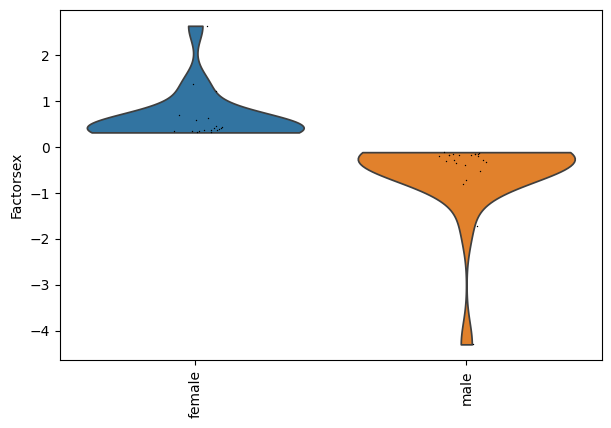

In [21]:
sc.pl.violin(amodelSOFA, "Factorsex", groupby="sex", rotation=90)

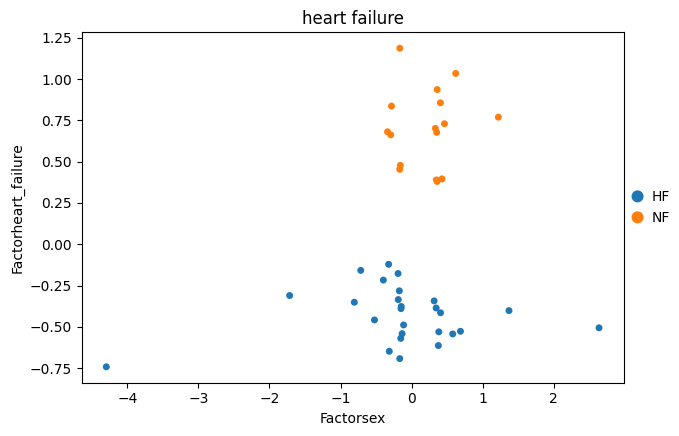

In [22]:
sc.pl.scatter(amodelSOFA, x="Factorsex", y="Factorheart_failure", color="heart_failure", size=100)